# Tutorial: Deal Exit Simulator

## Introduction

This document explains how to use the Deal Exit Simulator endpoints of the **Private Equity Model API** provided by [prettymodels.ai](https://prettymodels.ai).
Our model is based on [Tausch, Buchner, Schlüchtermann (2022)](https://doi.org/10.21314/JOR.2022.029).

Important assumptions:
- per deal we model only one entry cash flow and exit cash flow
- exit timing and exit multiple are dependent (i.e., not independent)
- macroeconomic variables influence the extit timing and the exit multiple
- our model follows a reduced-form approach (not a strucutral approach, compare to [credit risk models]( https://doi.org/10.1002/9781119201892.ch6))


## Setup Python and API keys

In [1]:
# Load packages
import os
import requests
import pandas as pd

In [2]:
# Define the API root URL

# EVERY USER NEEDS TO DO THIS !!!

base_product_url = "https://base-product-url.app"
primary_api_key = "needed-for-authentication"
secondary_api_key = "needed-for-authentication"

if (base_product_url == "https://base-product-url.app"):
    print("IMPORTANT: You need to MANUALLY set the correct base_product_url and primary_api_key!")
    from api_root import primary_api_key, secondary_api_key, base_product_url

IMPORTANT: You need to MANUALLY set the correct base_product_url and primary_api_key!


## Available endpoints in the Deal Exit Simulator module

In [3]:
# DEAL EXIT SIMULATOR MODEL
model = "tbs_22"

endpoints = [
    "cash_flow_expectations",
    "cash_flow_quantiles?quantile=0.2", # enter your own quantile here as API query parameter
    "cash_flow_quantiles?quantile=0.5",
    "cash_flow_quantiles?quantile=0.9",
    "cash_flow_paths",
]

## Check available fund segments and macro environments

In [4]:
# Check available fund_segments and macro_environments (directly from the API)

fund_segments = requests.get(os.path.join(base_product_url, "common/fund_segments"))
print("fund_segments", fund_segments.json())
macro_environments = requests.get(
    os.path.join(base_product_url, "common/macro_environments")
)
print("macro_environments", macro_environments.json())

fund_segments ['BO', 'VC', 'PE', 'RE', 'PD', 'INF', 'NATRES', 'FOF']
macro_environments ['average', 'medium', 'super', 'good', 'bad', 'evil']


## Define the API request body

Specify your input parameters in the request body:

- Performance:
    - **fund_segment**: choose from \[BO, VC, PE, RE, PD, INF, NATRES, FOF\]
    - **macro_environment**: choose from \[average, medium, super, good, bad, evil\]
- Timing:
    - **deal_age**: current deal age (in years)
    - **fund_age_at_entry**: fund age at deal entry (in years)
- Current Deal Multiples:
    - **current_deal_fmv**: current deal fmv (fair market value), all exit cash flow take this fmv as basis
    - **current_deal_rvpi**: current residual-value-to-paid-in ratio of the deal, i.e., fmv/cost

**Please enter your own parameter assumptions!**

In [5]:
# Define the request body

request_body = {
    "macro_environment": macro_environments.json()[0],
    "fund_segment": fund_segments.json()[0],
    "deal_age": 0,
    "fund_age_at_entry": 0,
    "current_deal_fmv": 1,
    "current_deal_rvpi": 1,
}

## Run the API requests

POST request successful: cash_flow_expectations
POST request successful: cash_flow_quantiles?quantile=0.2
POST request successful: cash_flow_quantiles?quantile=0.5
POST request successful: cash_flow_quantiles?quantile=0.9
POST request successful: cash_flow_paths


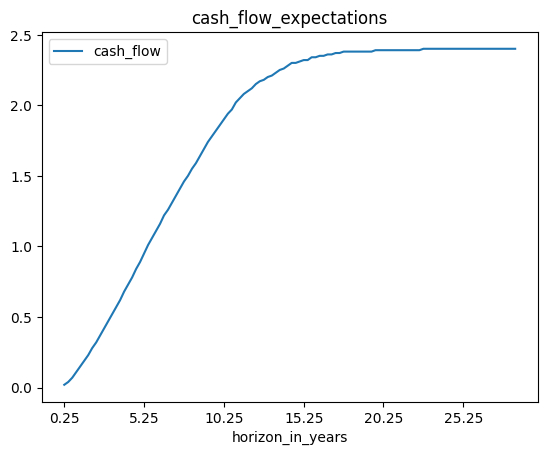

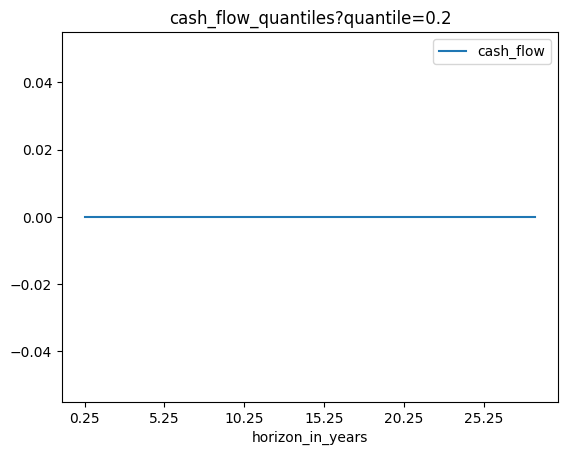

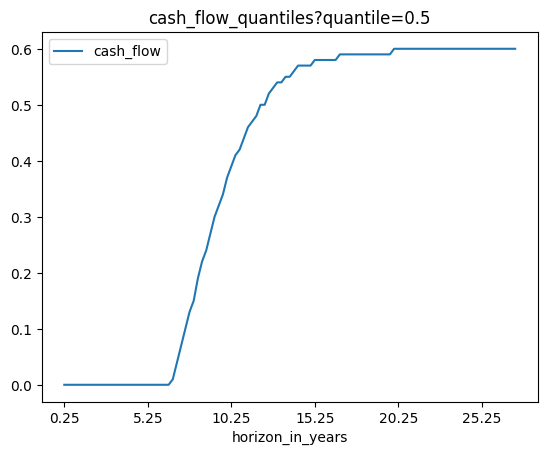

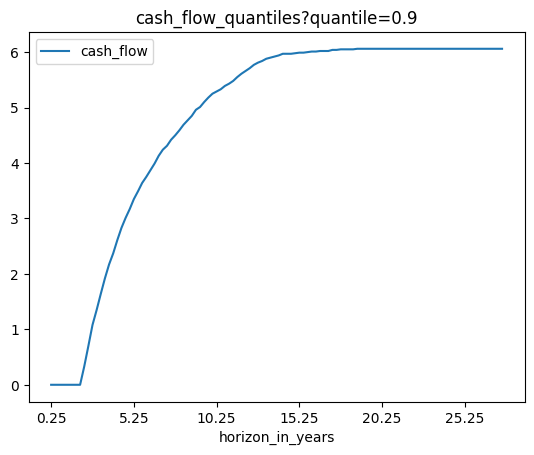

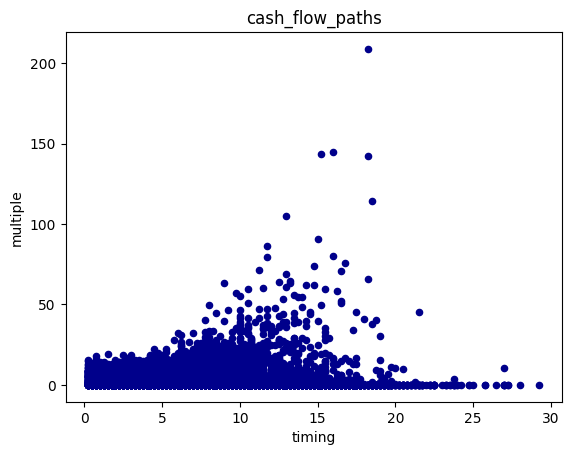

In [6]:
for endpoint in endpoints:
    # Build API URL
    url = os.path.join(base_product_url, model, endpoint)

    # Set header for authentication
    headers = {"X-BLOBR-KEY": primary_api_key}

    # Send the POST request
    response = requests.post(url, json=request_body, headers=headers)

    if response.status_code == 401:
        # needed for API Key Rotation
        # More info: https://www.blobr.io/post/api-keys-best-practices
        headers = {"X-BLOBR-KEY": secondary_api_key}
        response = requests.post(url, json=request_body, headers=headers)

    # Check the response status code
    if response.status_code == 200:
        # Request was successful
        print(f"POST request successful: {endpoint}")
        # print("Response JSON:", response.json())
    else:
        # Request failed
        print("POST request failed with status code:", response.status_code)

    # Convert dict to pd.DataFrame
    if endpoint == "cash_flow_paths":
        df = pd.DataFrame.from_dict(response.json())
        df.index.name = "path_number"
    else:
        df = pd.DataFrame(response.json(), index=["cash_flow"]).T
        df.index.name = "horizon_in_years"
    # print("df", df.columns, df)

    # Save pd.DataFrame to .csv file
    df.to_csv(f"deal_exit_simulator---{endpoint}.csv")
    if endpoint == "cash_flow_paths":
        plot = df.plot.scatter(x="timing", y="multiple", c="DarkBlue", title=endpoint)
    else:
        plot = df.plot(title=endpoint)
        